Here, we investigate the potential violation of a valid 2sample test following gcca on data with pairwise correlations

In [2]:
from hyppo.independence import Dcorr
from hyppo.ksample._utils import k_sample_transform
from mvlearn.embed import GCCA
import numpy as np

from collections import defaultdict
from scipy.spatial.distance import squareform, pdist
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

# custom seaborn plot options to make the figures pretty
sns.set(color_codes=True, style='white', context='notebook', font_scale=1.25)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

import warnings
warnings.filterwarnings('ignore')

In [97]:
def simulate_2sample_null(n1, n2=None, d=100, group_std=0.1, seed=None):
    """
    Simulates a set of paired observations for a 2-sample test.
    
    n1,n2 : size of the two groups. Are both n1 if n2 is None
    d : dimension of observations
    group_std : standard deviation of normal distribution around group mean
    """
    np.random.seed(seed)
    
    # Means for each observation
    mus1 = np.random.normal(0,1,(n1,d))
    if n2 is None:
        n2 = n1
    mus2 = np.random.normal(0,1,(n2,d))
    
    # Paired observations
    X = np.vstack(
        [np.random.normal(mu, group_std, (2,d)) for mu in mus1]  +
        [np.random.normal(mu, group_std, (2,d)) for mu in mus2]
    )        
    return X

def simulate_multiviews_null(n_view_pairs, n, d=100, group_std=0.1, seed=None, dist=np.random.normal, dist_kwargs={'loc':0, 'scale':1}):
    """
    Simulates multivariate gaussian data of shape (n_niews, n, d)
    where sequential pairs in the 1st dimension are correlated
    """
    np.random.seed(seed)

    mus = [dist(**dist_kwargs,size=(n,d)) for i in range(n_view_pairs)]
    X = np.asarray(np.vstack([
        [np.random.normal(mu, group_std), np.random.normal(mu, group_std)] for mu in mus
    ]))
    
    return X

In [51]:
# Simulation parameters
n_views = 25
n = 1000
d = 100
group_std = 0.1

N_DATASETS = 100
REPS = 250

In [47]:
Xs.shape

(50, 1000, 100)

In [76]:
# Labels
Y_within = np.asarray([0, 1] * (n_views))
#Y_across = np.hstack(([0] * n1 * 2, [1] * n2 * 2))

# Permutation tree blocks
blocks_within = -1*np.hstack([[i+1]*2 for i in range(n_views)]).T
# blocks_across = np.c_[
#     np.hstack([[i+1]*2 for i in range(n1+n2)]),
#     -1*Y_within - 1
# ]

REPS = 500
test_results = []

In [80]:
print(len(test_results))

80


In [82]:
for i in range(N_DATASETS):
    if i % 25 == 0:
        print(i, end=' ')
    Xs = simulate_multiviews_null(n_views, n, d, seed=i+len(test_results))
    components = GCCA(n_components=1).fit_transform(Xs)
    _, pval = Dcorr().test(
        components[:,:,0],
        Y_within,
        reps=REPS,
        workers=-1,
        #auto=False,
        perm_blocks=blocks_within,
    )
    test_results.append(pval)

0 25 50 75 

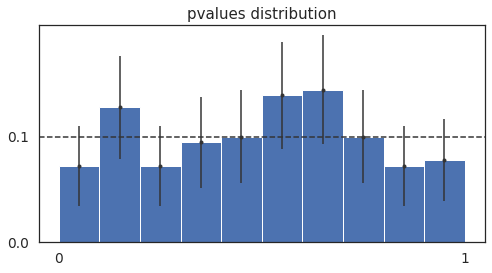

In [92]:
#fig, axes = plt.subplots(2,3, figsize=(4, 4*len(data_dict.keys())))
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(111)#, sharey=ax)
N = len(test_results)
entries, edges, _ = ax.hist(test_results, bins = np.arange(0,1.1,0.1), weights=np.ones(N)/N, color='b')
# entries = height of each column = proportion in that bin
# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])
ax.axhline(y=sum(entries) / len(bin_centers), ls='--', c='#333333')
# errorbars are binomial proportion confidence intervals
ax.errorbar(
    bin_centers, entries,
    yerr = 1.96 * np.sqrt(entries * (1 - entries) / N),
    fmt='.',c='#333333'
)
ax.set_title(f'pvalues distribution')

ax.set_xticks([0,1])

ax.set_yticks([0,0.1])
#ax.set_yticks([0, 0.1, 1])

plt.show()

### Fat tailed sampels (pareto dist)

In [95]:
results_pareto = []

In [98]:
print(f'Results list length: {len(results_pareto)}')
for i in range(N_DATASETS):
    if i % 25 == 0:
        print(i, end=' ')
    Xs = simulate_multiviews_null(n_views, n, d, seed=i+len(test_results),
                                  dist=np.random.pareto,dist_kwargs={'a':3})
    components = GCCA(n_components=1).fit_transform(Xs)
    _, pval = Dcorr().test(
        components[:,:,0],
        Y_within,
        reps=REPS,
        workers=-1,
        #auto=False,
        perm_blocks=blocks_within,
    )
    results_pareto.append(pval)

0
0 25 50 75 

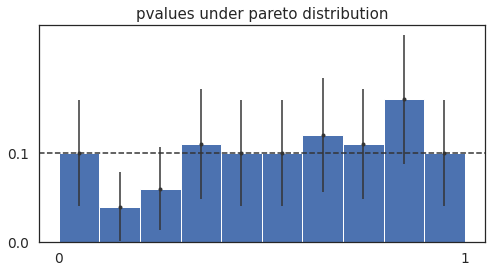

In [99]:
#fig, axes = plt.subplots(2,3, figsize=(4, 4*len(data_dict.keys())))
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(111)#, sharey=ax)
N = len(results_pareto)
entries, edges, _ = ax.hist(results_pareto, bins = np.arange(0,1.1,0.1), weights=np.ones(N)/N, color='b')
# entries = height of each column = proportion in that bin
# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])
ax.axhline(y=sum(entries) / len(bin_centers), ls='--', c='#333333')
# errorbars are binomial proportion confidence intervals
ax.errorbar(
    bin_centers, entries,
    yerr = 1.96 * np.sqrt(entries * (1 - entries) / N),
    fmt='.',c='#333333'
)
ax.set_title(f'pvalues under pareto distribution')

ax.set_xticks([0,1])

ax.set_yticks([0,0.1])
#ax.set_yticks([0, 0.1, 1])

plt.show()

### Third gradient

In [104]:
results_pareto3 = []

In [105]:
print(f'Results list length: {len(results_pareto3)}')
for i in range(N_DATASETS):
    if i % 25 == 0:
        print(i, end=' ')
    Xs = simulate_multiviews_null(n_views, n, d, seed=i+len(test_results),
                                  dist=np.random.pareto,dist_kwargs={'a':3})
    components = GCCA(n_components=3).fit_transform(Xs)
    _, pval = Dcorr().test(
        components[:,:,2],
        Y_within,
        reps=REPS,
        workers=-1,
        #auto=False,
        perm_blocks=blocks_within,
    )
    results_pareto3.append(pval)

Results list length: 0
0 25 50 75 

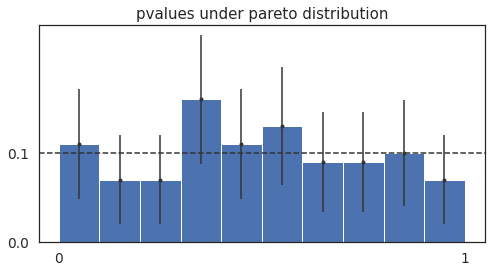

In [106]:
#fig, axes = plt.subplots(2,3, figsize=(4, 4*len(data_dict.keys())))
fig = plt.figure(figsize=(8, 4))

ax = fig.add_subplot(111)#, sharey=ax)
N = len(results_pareto3)
entries, edges, _ = ax.hist(results_pareto3, bins = np.arange(0,1.1,0.1), weights=np.ones(N)/N, color='b')
# entries = height of each column = proportion in that bin
# calculate bin centers
bin_centers = 0.5 * (edges[:-1] + edges[1:])
ax.axhline(y=sum(entries) / len(bin_centers), ls='--', c='#333333')
# errorbars are binomial proportion confidence intervals
ax.errorbar(
    bin_centers, entries,
    yerr = 1.96 * np.sqrt(entries * (1 - entries) / N),
    fmt='.',c='#333333'
)
ax.set_title(f'pvalues under pareto distribution')

ax.set_xticks([0,1])

ax.set_yticks([0,0.1])
#ax.set_yticks([0, 0.1, 1])

plt.show()